In this notebook, we will 
- Make a feed forward neural network (NN) model with 59 Rdkit descriptors
- Predict the ERed of molecules in the test dataset
- save the model with pickle package

In [57]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# import custom functions from the python file
import sys
sys.path.append('../') # path of the directory that contains Chemfunctions.py
import Chemfunctions as chemfun


# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# RDKit 
import rdkit.Chem as Chem

Need val data for training NN so read the unscaled train features


In [58]:
X_train = pd.read_csv(r'./Data/X_train_70pc_unscaled.csv')
X_test = pd.read_csv(r'./Data/X_test_30pc_unscaled.csv')
y_train = pd.read_csv(r'./Data/y_train_70pc_target.csv')
y_test = pd.read_csv(r'./Data/y_test_30pc_target.csv')

print(f'X_train.shape={X_train.shape}, y_train.shape={y_train.shape}')
print(f'X_test.shape={X_test.shape}, y_test.shape={y_test.shape}')

X_train.shape=(3809, 59), y_train.shape=(3809, 1)
X_test.shape=(1633, 59), y_test.shape=(1633, 1)


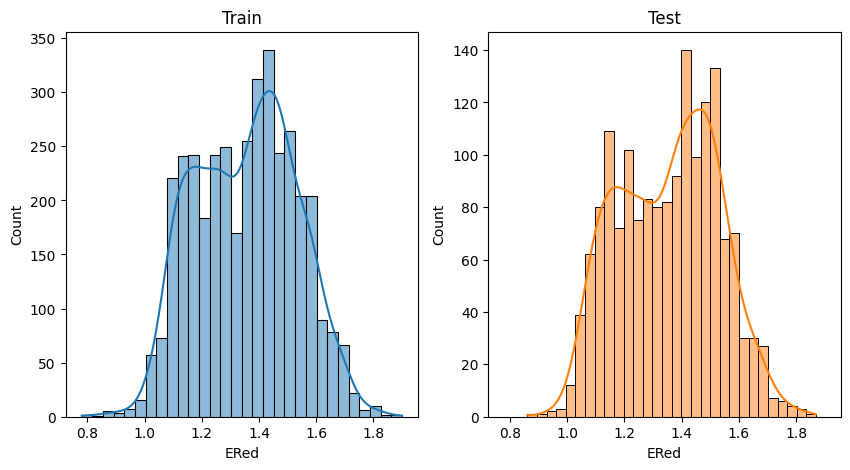

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
sns.histplot(ax=axs[0],x=y_train["ERed"], bins=30, kde=True,color="tab:blue")
sns.histplot(ax=axs[1],x=y_test["ERed"], bins=30, kde=True,color="tab:orange")
axs[0].set_xlabel("ERed")
axs[1].set_xlabel("ERed")
axs[0].set_ylabel("Count")
axs[1].set_ylabel("Count")
axs[0].set_title("Train")
axs[1].set_title("Test")
plt.show()

# NN model

In [60]:
import tensorflow as tf

let's make a neural network (NN) with an input layer of size of X_train.shape[1], with tf we need to pass input_shape as iterable object so [X_train.shape[1]] will run w/o error

NN will have 
- 1st hidden layer with 64 units and relu activation
- 2nd hidden layer with 32 units and relu activation
- 3rd hidden layer with 16 units and sigmoid activation
- output layer with 1 unit

In [61]:
input_shape=[X_train.shape[1]]
model = tf.keras.Sequential([

	tf.keras.layers.Dense(units=64, activation='relu',
						input_shape=input_shape),
	tf.keras.layers.Dense(units=32, activation='relu'),
	tf.keras.layers.Dense(units=16, activation='sigmoid'),
	# tf.keras.layers.Dense(units=1,activation='linear')
	tf.keras.layers.Dense(units=1)
])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                3840      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


In [62]:
# adam optimizer works pretty well for
# all kinds of problems and is a good starting point
model.compile(optimizer='adam',
			
			# MAE error is good for
			# numerical predictions
			loss='mean_squared_error')


Make a val set and scale test data set too

In [63]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X_train,y_train,test_size=0.1, random_state=32)
print(f'train_x.shape = {train_x.shape}, val_x.shape = {val_x.shape}, train_y.shape = {train_y.shape}, val_y.shape = {val_y.shape}')

train_x.shape = (3428, 59), val_x.shape = (381, 59), train_y.shape = (3428, 1), val_y.shape = (381, 1)


scaling

In [64]:
temp=train_x.copy()
train_x,val_x=chemfun.do_scaling(xtrain=train_x,xtest=val_x)
_,test_x=chemfun.do_scaling(xtrain=temp,xtest=X_test)

returning scaled train and test data
returning scaled train and test data


In [65]:
losses = model.fit(train_x, train_y,

				validation_data=(val_x,val_y),
					
				# it will use 'batch_size' number
				# of examples per example
				batch_size=128,
				epochs=30, # total epoch

				)


Epoch 1/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0089
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 5/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 7/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0058
Epoch 8/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 9/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 10/30
27/27 [==============================] - 0s 2ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 11/30
27/27 [

<AxesSubplot: >

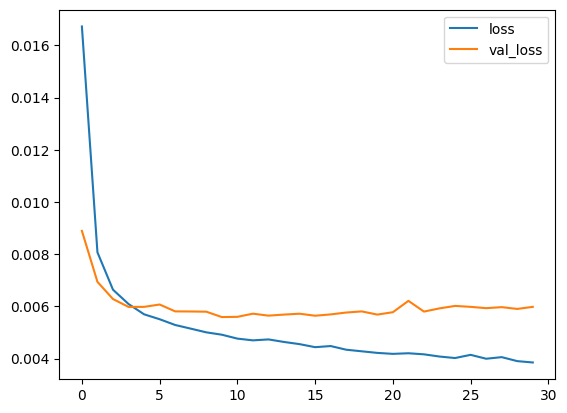

In [66]:
loss_df = pd.DataFrame(losses.history)

# history stores the loss/val
# loss in each epoch

# loss_df is a dataframe which
# contains the losses so we can
# plot it to visualize our model training
loss_df.loc[:,['loss','val_loss']].plot()

In [67]:
def pairity_plot2(model,X_train,X_test,y_train,y_test):
    import matplotlib.pyplot as plt
    """
    This function will fit the model and make parity plot with residuals
    """
    # model.fit(X_train,y_train)
    # print(y_test.shape,y_train.shape)
    
    ytest_pred=model.predict(X_test)

    ytrain_pred=model.predict(X_train)
    
    ytrain_pred=np.array(ytrain_pred).reshape(-1,1)
    ytest_pred=np.array(ytest_pred).reshape(-1,1)
    y_test=np.array(y_test).reshape(-1,1)
    y_train=np.array(y_train).reshape(-1,1)

    fig, axs = plt.subplots(1,2,figsize=(10,5),sharex=True)
    
    fig.suptitle(f"model={model}")

    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import r2_score as r2

    axs[0].plot([y_train.min()-0.05,y_train.max()+0.05],[y_train.min()-0.05,y_train.max()+0.05],':k',linewidth=2)
    axs[0].set_xlim([y_train.min()-0.05,y_train.max()+0.05])
    axs[0].set_ylim([y_train.min()-0.05,y_train.max()+0.05])
    axs[0].set_xlabel('Predicted (V)')
    axs[0].set_ylabel('DFT Calculated (V)')

    errors_=f"Train: R2 = {r2(y_true=y_train,y_pred=ytrain_pred):0.2f},RMSE = {np.sqrt(mse(y_true=y_train,y_pred=ytrain_pred)):0.2f}"
    axs[0].scatter(ytrain_pred,y_train,label=errors_)
    
    errors_=f"Test: R2 = {r2(y_true=y_test,y_pred=ytest_pred):0.2f},RMSE = {np.sqrt(mse(y_true=y_test,y_pred=ytest_pred)):0.2f}"
    axs[0].scatter(ytest_pred,y_test,label=errors_)

    axs[0].legend()

    axs[1].scatter(ytest_pred,(y_test-ytest_pred))
    axs[1].plot([y_train.min()-0.05,y_train.max()+0.05],[0,0],':k',linewidth=2)
    axs[1].set_xlabel('Predicted (V)')
    # axs[0].set_xlabel('Predicted (V)')
    axs[1].set_ylabel('Residual = Actual - Predicted (V)')
    plt.show()

108/108 [==============================] - 0s 595us/step


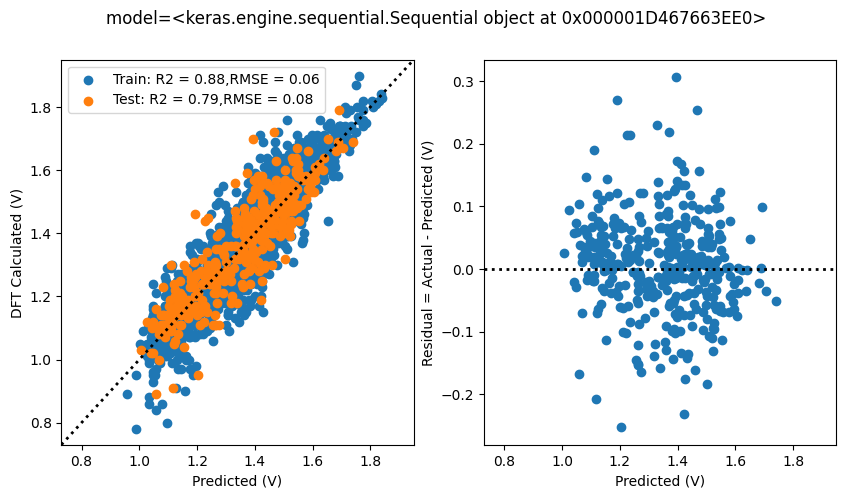

In [68]:
pairity_plot2(model=model,X_train=train_x,X_test=val_x,y_train=train_y["ERed"],y_test=val_y["ERed"])

108/108 [==============================] - 0s 538us/step


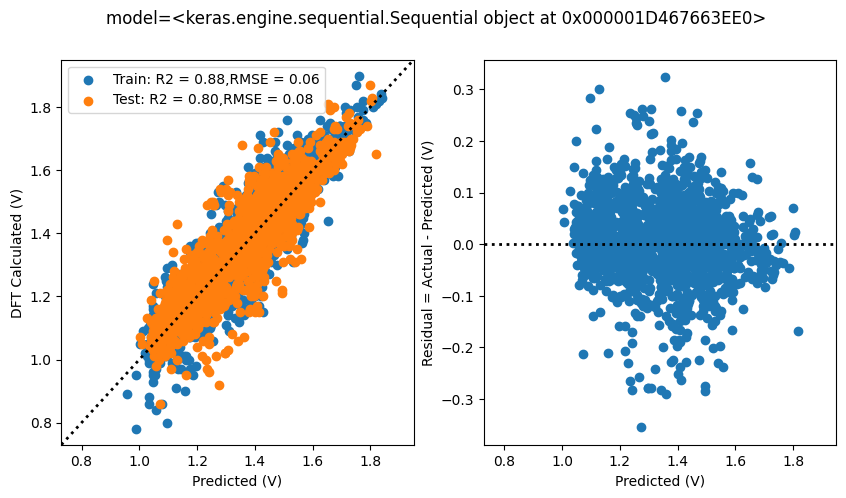

In [69]:
pairity_plot2(model=model,X_train=train_x,X_test=test_x,y_train=train_y["ERed"],y_test=y_test["ERed"])

Save model

In [70]:
## save model
save_path = r'./Models/NN_Regression.h5'
model.save(save_path)
## load tensorflow model
# model = tf.keras.models.load_model(save_path)

In [72]:
test_x.to_csv(r'./Data/X_test_30pc_scaled_nn.csv',index=False)
# test_y = y_test
train_x.to_csv(r'./Data/X_train_70pc_90v_scaled_nn.csv',index=False)
val_x.to_csv(r'./Data/X_val_70pc_10v_scaled_nn.csv',index=False)

train_y.to_csv(r'./Data/y_train_70pc_90v_scaled_nn.csv',index=False)
val_y.to_csv(r'./Data/y_val_70pc_10v_scaled_nn.csv',index=False)